In [51]:
import pyro
import pyro.contrib.gp as gp
import torch
dist = torch.distributions
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [76]:
kernel1 = gp.kernels.Linear(input_dim=1)
kernel2 = gp.kernels.Linear(input_dim=1)

kernel2 = gp.kernels.Periodic(input_dim=1, period=torch.tensor(1.), lengthscale=torch.tensor(1.))

In [207]:

def plot_combination(k1, k2, k1_name, k2_name, method='sum', ax = None):
    pyro.clear_param_store()
    if method=='sum':
        combined_k = gp.kernels.Sum(kern0=kernel1, kern1=kernel2)
        title = f"{k1_name} + {k2_name}"
    else:
        combined_k = gp.kernels.Product(kern0=kernel1, kern1=kernel2)
        title = f"{k1_name} X {k2_name}"
        
        
    if ax is None:
        fig, ax = plt.subplots()
    
    n_test = 100
    Xtest = torch.linspace(-5, 5, n_test)  # test inputs
    
    cov, samples = get_sample(combined_k, Xtest)
    ax.plot(Xtest.numpy(), samples.numpy().T, lw=3)
    
    ax.set_title(title)
    sns.despine()

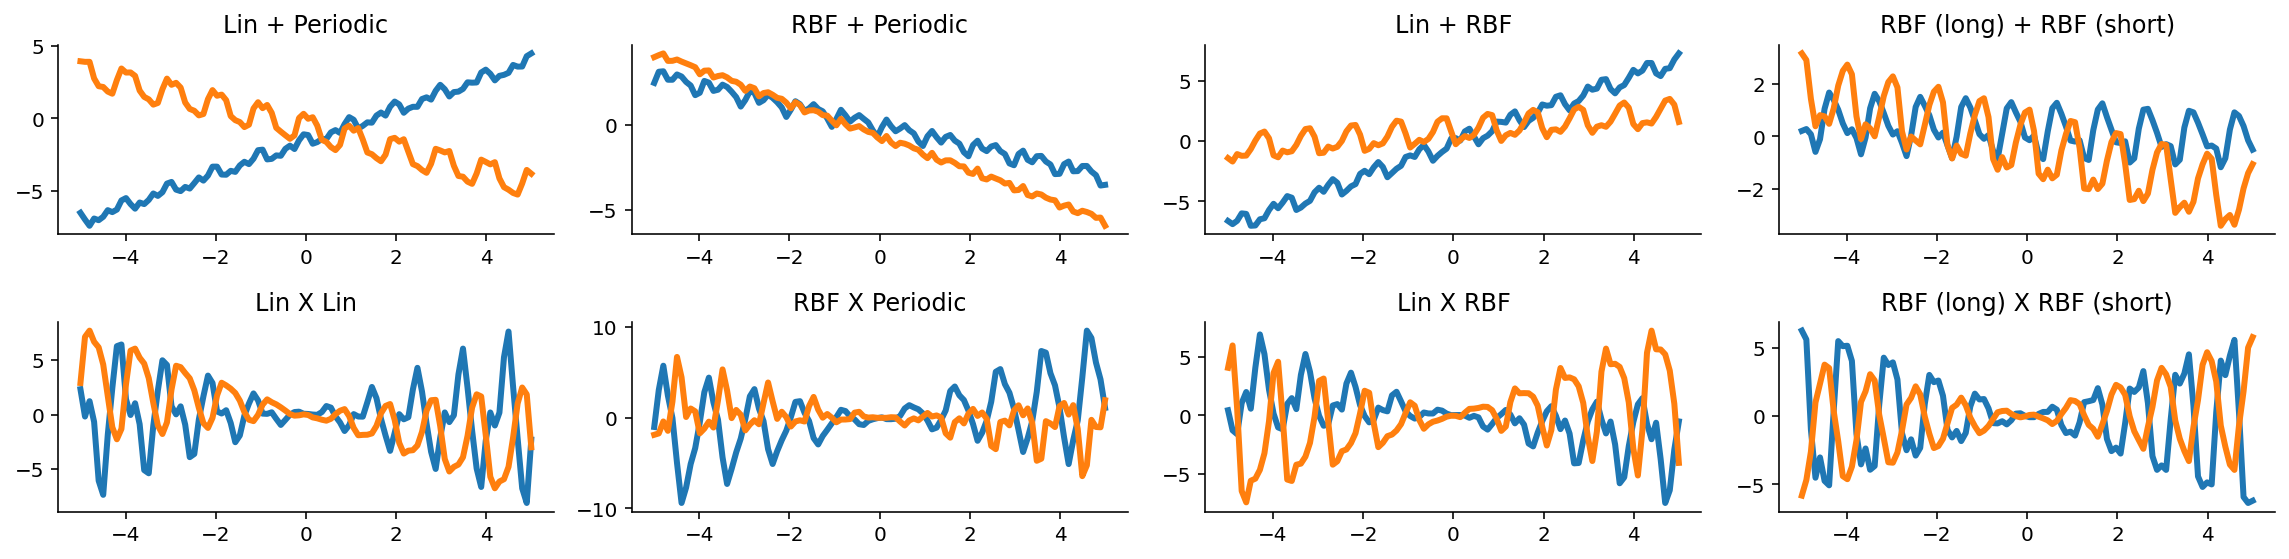

In [261]:
fig, ax  = plt.subplots(nrows=2, ncols=4, figsize=(16, 4), sharex=False, sharey=False)

linear = gp.kernels.Linear(input_dim=1, )
periodic  = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.5), lengthscale=torch.tensor(4.))
rbf = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(0.5), variance=torch.tensor(0.5))
rbf_long = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(5.), variance=torch.tensor(1))




plot_combination(linear, periodic, 'Lin', 'Periodic', method='sum', ax=ax[0, 0])


plot_combination(rbf, periodic, 'RBF', 'Periodic', method='sum', ax=ax[0, 1])

plot_combination(linear, rbf, 'Lin', 'RBF', method='sum', ax=ax[0, 2])
plot_combination(rbf_long, rbf, 'RBF (long)', 'RBF (short)', method='sum', ax=ax[0, 3])




plot_combination(linear, linear, 'Lin', 'Lin', method='prod', ax=ax[1, 0])


plot_combination(rbf, periodic, 'RBF', 'Periodic', method='prod', ax=ax[1, 1])

plot_combination(linear, rbf, 'Lin', 'RBF', method='prod', ax=ax[1, 2])
plot_combination(rbf_long, rbf, 'RBF (long)', 'RBF (short)', method='prod', ax=ax[1, 3])

fig.tight_layout()

In [191]:
def get_sample(k, Xtest):
    
    noise = torch.tensor(0.001)
    with torch.no_grad():
        cov = k.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(2,))
        return cov, samples

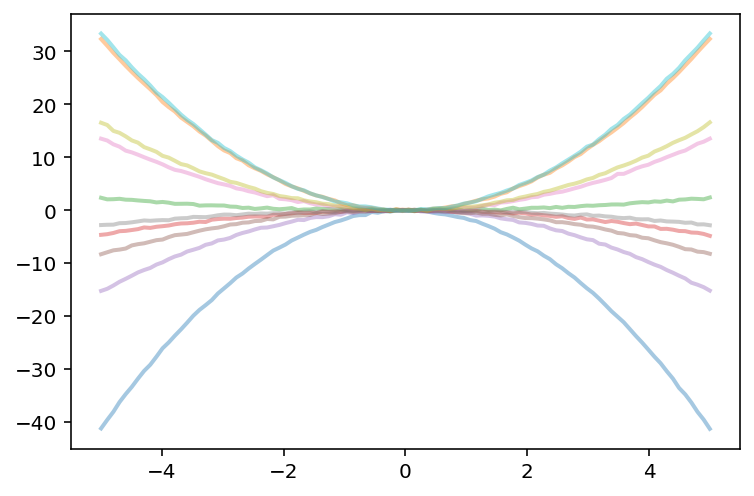

In [192]:


noise = torch.tensor(0.01)
cov = combined_k.forward(Xtest) + noise.expand(n_test).diag()
samples = dist.MultivariateNormal(
    torch.zeros(n_test), covariance_matrix=cov
).sample(sample_shape=(10,))
plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

In [193]:
combined_k.forward?

In [104]:
Xtest.shape

torch.Size([100])

In [111]:
torch.linalg.cholesky(combined_k.forward(Xtest, torch.ones_like(Xtest)))

RuntimeError: torch.linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 51 is not positive-definite).

Text(0, 0.5, 'Samples')

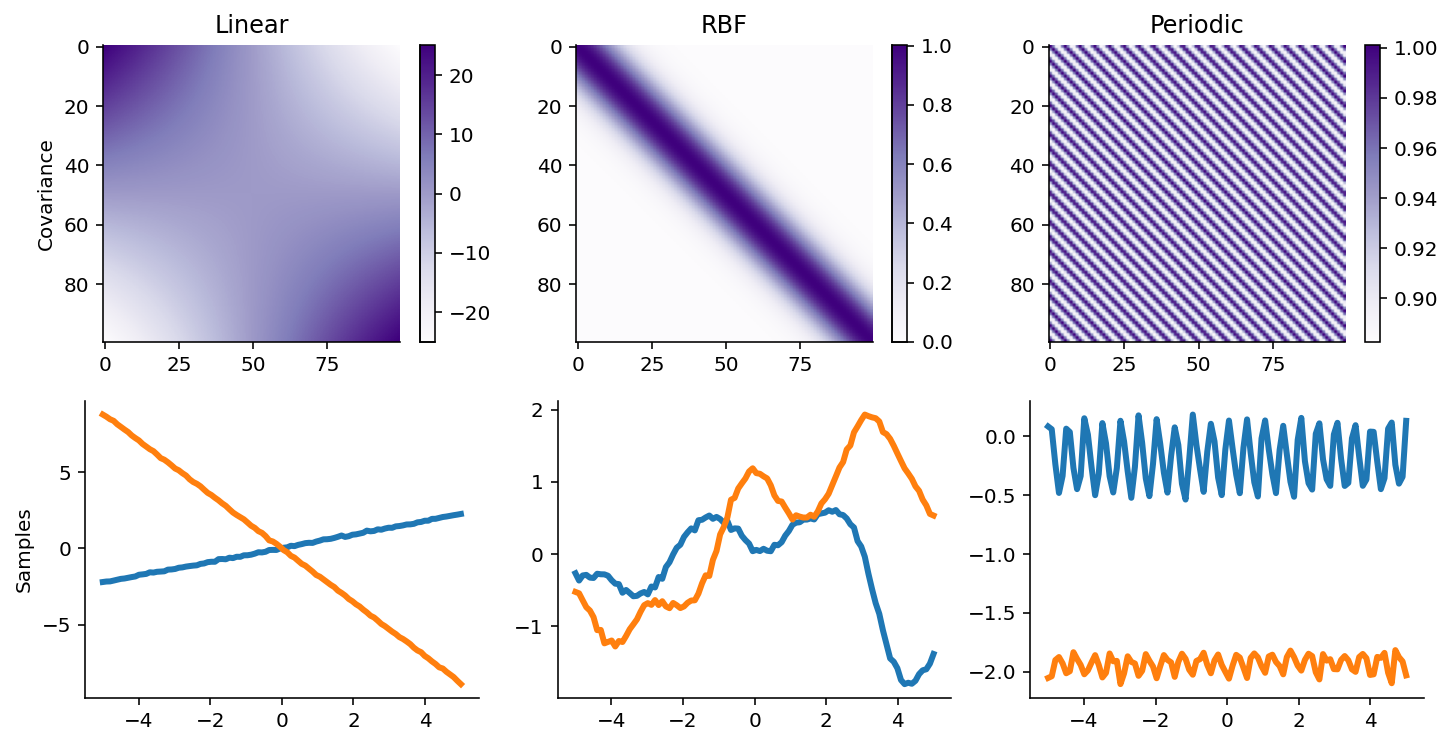

In [206]:
 # test inputs

fig, ax = plt.subplots(ncols=3, nrows=2,  figsize=(12, 6))
for i, (k_name, k) in enumerate(zip(["Linear", 'RBF', 'Periodic'], [linear, rbf, periodic])):
    Xtest = torch.linspace(-5, 5, 100)
    cov, samples = get_sample(k, Xtest)
    ax[1, i].plot(Xtest.numpy(), samples.numpy().T, lw=3)
    ax[0, i].set_title(k_name)
    sns.despine()
    
    img = ax[0, i].imshow(cov, cmap='Purples')
    fig.colorbar(img, ax = ax[0, i],)
    
ax[0, 0].set_ylabel("Covariance")
ax[1, 0].set_ylabel("Samples")

In [222]:
cov, samples = get_sample(linear, Xtest)

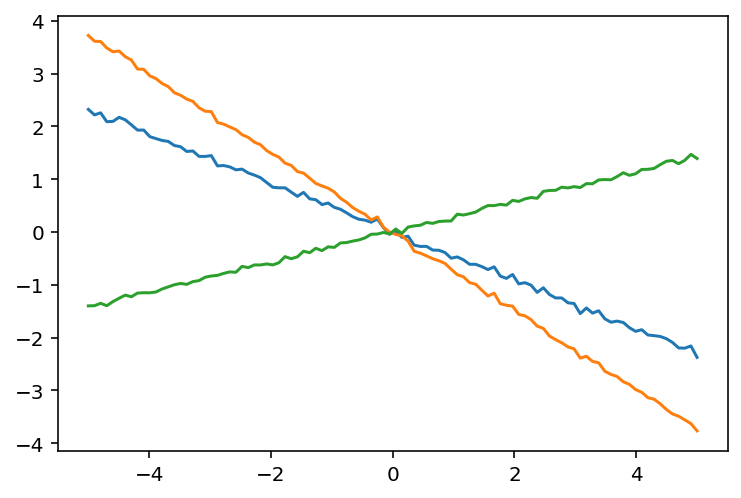

In [223]:
plt.plot(Xtest, torch.sum(samples, axis=0))
plt.plot(Xtest, samples.T)

In [225]:
rbf.lengthscale

tensor(1., grad_fn=<AddBackward0>)

In [226]:
linear.variance

tensor(1., grad_fn=<AddBackward0>)

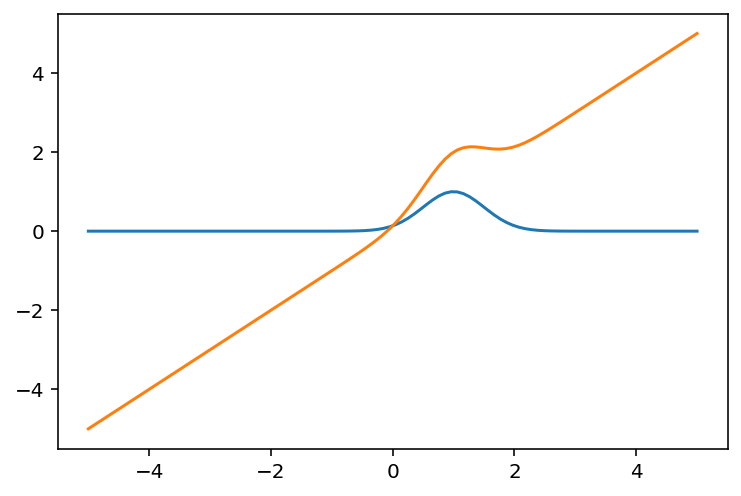

In [253]:
for k in [rbf, gp.kernels.Sum(kern0=rbf, kern1=linear)]:
    with torch.no_grad():
        plt.plot(Xtest, k.forward(Xtest, torch.ones(1)).squeeze())
        cov = k.forward(Xtest, torch.ones(1)).squeeze()
        

In [254]:
cov

tensor([-5.0000, -4.8990, -4.7980, -4.6970, -4.5960, -4.4949, -4.3939, -4.2929,
        -4.1919, -4.0909, -3.9899, -3.8889, -3.7879, -3.6869, -3.5859, -3.4848,
        -3.3838, -3.2828, -3.1818, -3.0808, -2.9798, -2.8788, -2.7778, -2.6768,
        -2.5758, -2.4747, -2.3737, -2.2727, -2.1717, -2.0707, -1.9697, -1.8687,
        -1.7677, -1.6667, -1.5657, -1.4646, -1.3636, -1.2626, -1.1615, -1.0604,
        -0.9591, -0.8576, -0.7555, -0.6524, -0.5476, -0.4400, -0.3279, -0.2091,
        -0.0810,  0.0595,  0.2153,  0.3885,  0.5796,  0.7870,  1.0061,  1.2292,
         1.4464,  1.6467,  1.8194,  1.9563,  2.0533,  2.1107,  2.1338,  2.1313,
         2.1140,  2.0930,  2.0778,  2.0754,  2.0898,  2.1222,  2.1717,  2.2359,
         2.3119,  2.3967,  2.4877,  2.5827,  2.6804,  2.7796,  2.8796,  2.9802,
         3.0810,  3.1819,  3.2829,  3.3839,  3.4849,  3.5859,  3.6869,  3.7879,
         3.8889,  3.9899,  4.0909,  4.1919,  4.2929,  4.3939,  4.4949,  4.5960,
         4.6970,  4.7980,  4.8990,  5.00

In [270]:
X = torch.linspace(-5, 5, 100)
y = torch.sin(X*8) + 2*X + 4 + 0.2*torch.rand_like(X)

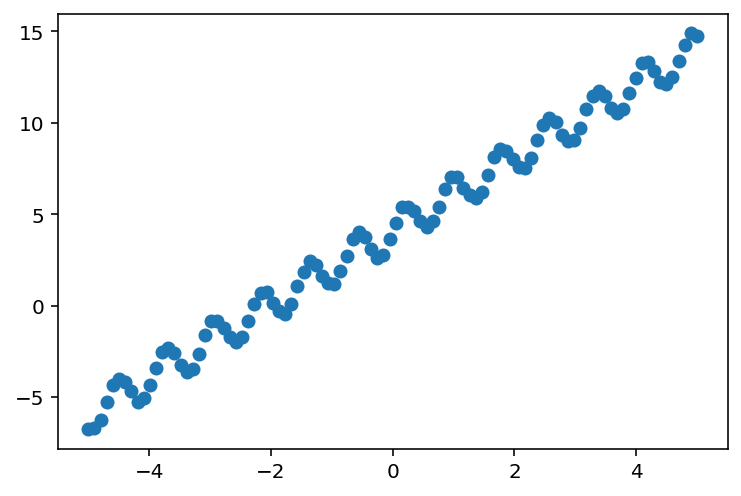

In [271]:
plt.scatter(X, y)

In [378]:
pyro.clear_param_store()
linear = gp.kernels.Linear(input_dim=1, )
linear2 = gp.kernels.Linear(input_dim=1, )


periodic  = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.5), lengthscale=torch.tensor(4.))
rbf = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(0.5), variance=torch.tensor(0.5))
rbf_long = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(5.), variance=torch.tensor(1))
k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)
k2 = gp.kernels.Sum(kern0=periodic, kern1=linear2)
#k2 = rbf
k = gp.kernels.Product(k1, k2)
k = gp.kernels.Sum(linear, k1)

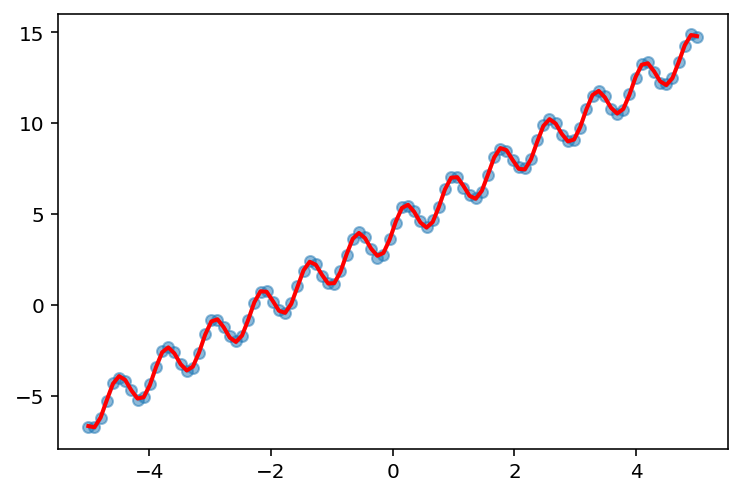

In [435]:
pyro.clear_param_store()
linear = gp.kernels.Linear(input_dim=1, )
linear2 = gp.kernels.Linear(input_dim=1, )


periodic  = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.5), lengthscale=torch.tensor(4.))
rbf = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(0.5), variance=torch.tensor(0.5))
rbf_long = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(5.), variance=torch.tensor(1))
k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)
k2 = gp.kernels.Sum(kern0=periodic, kern1=linear2)
#k2 = rbf
k = gp.kernels.Product(k1, k2)
k = gp.kernels.Sum(linear, k1)
fit_plot_kernel(k)
    

In [432]:
def fit_plot_kernel(ker, ax=None, title=None):
    pyro.clear_param_store()
    if ax is None:
        fig, ax = plt.subplots()
    likelihood = gp.likelihoods.Gaussian()
    model = gp.models.GPRegression(
    X, y, ker,jitter=0.01)
    loss = gp.util.train(model, num_steps=1500)
    with torch.no_grad():

        mean, cov = model(X, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
        Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd).numpy(),
        (mean + 2.0 * sd).numpy(),
        color="C0",
        alpha=0.3,
        )
    
        ax.scatter(X, y, s = 30, alpha=0.5)
        if title is not None:
            ax.set_title(title)

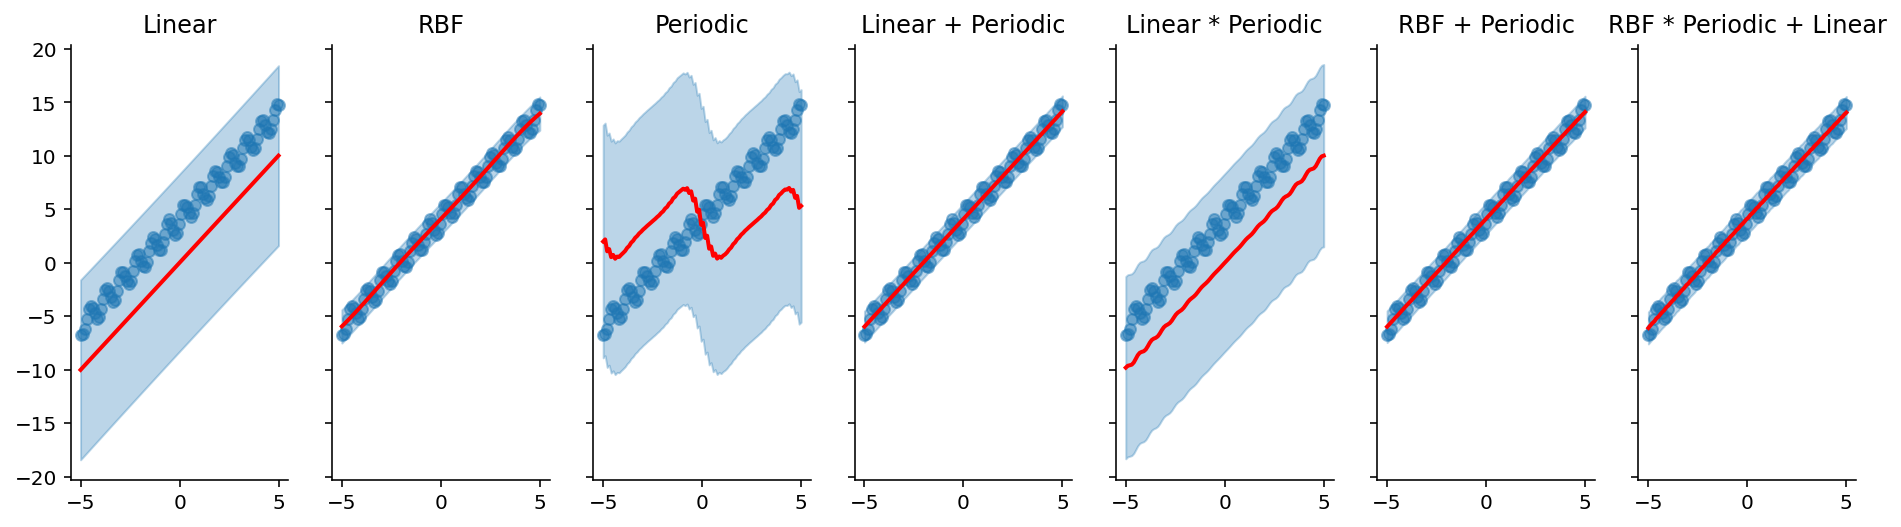

In [434]:
pyro.clear_param_store()
linear = gp.kernels.Linear(input_dim=1, )
linear2 = gp.kernels.Linear(input_dim=1, )


periodic  = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.01), lengthscale=torch.tensor(0.2))
rbf = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(0.5), variance=torch.tensor(0.5))

fig, ax = plt.subplots(ncols=7, figsize=(16, 4), sharey=True)
fit_plot_kernel(linear, ax=ax[0], title='Linear')
fit_plot_kernel(rbf, ax=ax[1], title='RBF')
fit_plot_kernel(periodic, ax=ax[2], title='Periodic')
fit_plot_kernel(gp.kernels.Sum(periodic, linear), ax=ax[3], title='Linear + Periodic')
fit_plot_kernel(gp.kernels.Product(periodic, linear), ax=ax[4], title='Linear * Periodic')
fit_plot_kernel(gp.kernels.Sum(periodic, rbf), ax=ax[5], title='RBF + Periodic')
periodic  = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.01), lengthscale=torch.tensor(0.2))
rbf = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(0.5), variance=torch.tensor(0.5))
linear = gp.kernels.Linear(input_dim=1, )




fit_plot_kernel(gp.kernels.Sum(linear, gp.kernels.Product(periodic, rbf)), ax=ax[6], title='RBF * Periodic + Linear')



sns.despine()